The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install -U --pre mxnet-cu101mkl  # updating mxnet to at least v1.6
!pip install ..  # installing d2l


# Text Sentiment Classification: Using Convolutional Neural Networks (textCNN)

:label:`sec_sentiment_cnn`


In :numref:`chap_cnn`, we explored how to process
two-dimensional image data with two-dimensional convolutional neural
networks. In the previous language models and text classification tasks, we
treated text data as a time series with only one dimension, and naturally, we
used recurrent neural networks to process such data. In fact, we can also treat
text as a one-dimensional image, so that we can use one-dimensional
convolutional neural networks to capture associations between adjacent
words. This section describes a groundbreaking approach to applying
convolutional neural networks to text analysis: textCNN :cite:`Kim.2014`. First, import the packages and modules required for the experiment.

In [1]:
import d2l
from mxnet import gluon, init, np, npx
from mxnet.contrib import text
from mxnet.gluon import nn
npx.set_np()

batch_size = 64
train_iter, test_iter, vocab = d2l.load_data_imdb(batch_size)

## One-Dimensional Convolutional Layer

Before introducing the model, let's explain how a one-dimensional convolutional layer works. Like a two-dimensional convolutional layer, a one-dimensional convolutional layer uses a one-dimensional cross-correlation operation. In the one-dimensional cross-correlation operation, the convolution window starts from the leftmost side of the input array and slides on the input array from left to right successively. When the convolution window slides to a certain position, the input subarray in the window and kernel array are multiplied and summed by element to get the element at the corresponding location in the output array. As shown in :numref:`fig_conv1d`, the input is a one-dimensional array with a width of 7 and the width of the kernel array is 2. As we can see, the output width is $7-2+1=6$ and the first element is obtained by performing multiplication by element on the leftmost input subarray with a width of 2 and kernel array and then summing the results.

![One-dimensional cross-correlation operation. The shaded parts are the first output element as well as the input and kernel array elements used in its calculation: $0\times1+1\times2=2$. ](http://d2l.ai/_images/conv1d.svg)

:label:`fig_conv1d`


Next, we implement one-dimensional cross-correlation in the `corr1d` function. It accepts the input array `X` and kernel array `K` and outputs the array `Y`.

In [2]:
def corr1d(X, K):
    w = K.shape[0]
    Y = np.zeros((X.shape[0] - w + 1))
    for i in range(Y.shape[0]):
        Y[i] = (X[i: i + w] * K).sum()
    return Y

Now, we will reproduce the results of the one-dimensional cross-correlation operation in :numref:`fig_conv1d`.

In [3]:
X, K = np.array([0, 1, 2, 3, 4, 5, 6]), np.array([1, 2])
corr1d(X, K)

array([ 2.,  5.,  8., 11., 14., 17.])

The one-dimensional cross-correlation operation for multiple input channels is also similar to the two-dimensional cross-correlation operation for multiple input channels. On each channel, it performs the one-dimensional cross-correlation operation on the kernel and its corresponding input and adds the results of the channels to get the output. :numref:`fig_conv1d_channel` shows a one-dimensional cross-correlation operation with three input channels.

![One-dimensional cross-correlation operation with three input channels. The shaded parts are the first output element as well as the input and kernel array elements used in its calculation: $0\times1+1\times2+1\times3+2\times4+2\times(-1)+3\times(-3)=2$. ](../img/conv1d-channel.svg)

:label:`fig_conv1d_channel`


Now, we reproduce the results of the one-dimensional cross-correlation operation with multi-input channel in :numref:`fig_conv1d_channel`.

In [4]:
def corr1d_multi_in(X, K):
    # First, we traverse along the 0th dimension (channel dimension) of X and
    # K. Then, we add them together by using * to turn the result list into a
    # positional argument of the add_n function
    return sum(corr1d(x, k) for x, k in zip(X, K))

X = np.array([[0, 1, 2, 3, 4, 5, 6],
              [1, 2, 3, 4, 5, 6, 7],
              [2, 3, 4, 5, 6, 7, 8]])
K = np.array([[1, 2], [3, 4], [-1, -3]])
corr1d_multi_in(X, K)

array([ 2.,  8., 14., 20., 26., 32.])

The definition of a two-dimensional cross-correlation operation tells us that a one-dimensional cross-correlation operation with multiple input channels can be regarded as a two-dimensional cross-correlation operation with a single input channel. As shown in :numref:`fig_conv1d_2d`, we can also present the one-dimensional cross-correlation operation with multiple input channels in :numref:`fig_conv1d_channel` as the equivalent two-dimensional cross-correlation operation with a single input channel. Here, the height of the kernel is equal to the height of the input.

![Two-dimensional cross-correlation operation with a single input channel. The highlighted parts are the first output element and the input and kernel array elements used in its calculation: $2\times(-1)+3\times(-3)+1\times3+2\times4+0\times1+1\times2=2$. ](../img/conv1d-2d.svg)

:label:`fig_conv1d_2d`


Both the outputs in :numref:`fig_conv1d` and :numref:`fig_conv1d_channel` have only one channel. We
discussed how to specify multiple output channels in a two-dimensional
convolutional layer in
:numref:`sec_channels`.
Similarly,
we can also specify multiple output channels in the one-dimensional
convolutional layer to extend the model parameters in the convolutional layer.


## Max-Over-Time Pooling Layer

Similarly, we have a one-dimensional pooling layer. The max-over-time pooling layer used in TextCNN actually corresponds to a one-dimensional global maximum pooling layer. Assuming that the input contains multiple channels, and each channel consists of values on different timesteps, the output of each channel will be the largest value of all timesteps in the channel. Therefore, the input of the max-over-time pooling layer can have different timesteps on each channel.

To improve computing performance, we often combine timing examples of different lengths into a minibatch and make the lengths of each timing example in the batch consistent by appending special characters (such as 0) to the end of shorter examples. Naturally, the added special characters have no intrinsic meaning. Because the main purpose of the max-over-time pooling layer is to capture the most important features of timing, it usually allows the model to be unaffected by the manually added characters.

## The TextCNN Model

TextCNN mainly uses a one-dimensional convolutional layer and max-over-time pooling layer. Suppose the input text sequence consists of $n$ words, and each word is represented by a $d$-dimension word vector. Then the input example has a width of $n$, a height of 1, and $d$ input channels. The calculation of textCNN can be mainly divided into the following steps:

1. Define multiple one-dimensional convolution kernels and use them to perform convolution calculations on the inputs. Convolution kernels with different widths may capture the correlation of different numbers of adjacent words.
2. Perform max-over-time pooling on all output channels, and then concatenate the pooling output values of these channels in a vector.
3. The concatenated vector is transformed into the output for each category through the fully connected layer. A dropout layer can be used in this step to deal with overfitting.

![TextCNN design. ](http://d2l.ai/_images/textcnn.svg)

:label:`fig_conv1d_textcnn`


:numref:`fig_conv1d_textcnn` gives an example to illustrate the textCNN. The input here is a sentence with 11 words, with each word represented by a 6-dimensional word vector. Therefore, the input sequence has a width of 11 and 6 input channels. We assume there are two one-dimensional convolution kernels with widths of 2 and 4, and 4 and 5 output channels, respectively. Therefore, after one-dimensional convolution calculation, the width of the four output channels is $11-2+1=10$, while the width of the other five channels is $11-4+1=8$. Even though the width of each channel is different, we can still perform max-over-time pooling for each channel and concatenate the pooling outputs of the 9 channels into a 9-dimensional vector. Finally, we use a fully connected layer to transform the 9-dimensional vector into a 2-dimensional output: positive sentiment and negative sentiment predictions.

Next, we will implement a textCNN model. Compared with the previous section, in addition to replacing the recurrent neural network with a one-dimensional convolutional layer, here we use two embedding layers, one with a fixed weight and another that participates in training.

In [5]:
class TextCNN(nn.Block):
    def __init__(self, vocab_size, embed_size, kernel_sizes, num_channels,
                 **kwargs):
        super(TextCNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # The embedding layer does not participate in training
        self.constant_embedding = nn.Embedding(vocab_size, embed_size)
        self.dropout = nn.Dropout(0.5)
        self.decoder = nn.Dense(2)
        # The max-over-time pooling layer has no weight, so it can share an
        # instance
        self.pool = nn.GlobalMaxPool1D()
        # Create multiple one-dimensional convolutional layers
        self.convs = nn.Sequential()
        for c, k in zip(num_channels, kernel_sizes):
            self.convs.add(nn.Conv1D(c, k, activation='relu'))

    def forward(self, inputs):
        # Concatenate the output of two embedding layers with shape of
        # (batch size, number of words, word vector dimension) by word vector
        embeddings = np.concatenate((
            self.embedding(inputs), self.constant_embedding(inputs)), axis=2)
        # According to the input format required by Conv1D, the word vector
        # dimension, that is, the channel dimension of the one-dimensional
        # convolutional layer, is transformed into the previous dimension
        embeddings = embeddings.transpose(0, 2, 1)
        # For each one-dimensional convolutional layer, after max-over-time
        # pooling, an ndarray with the shape of (batch size, channel size, 1)
        # can be obtained. Use the flatten function to remove the last
        # dimension and then concatenate on the channel dimension
        encoding = np.concatenate([
            np.squeeze(self.pool(conv(embeddings)), axis=-1)
            for conv in self.convs], axis=1)
        # After applying the dropout method, use a fully connected layer to
        # obtain the output
        outputs = self.decoder(self.dropout(encoding))
        return outputs

Create a TextCNN instance. It has 3 convolutional layers with kernel widths of 3, 4, and 5, all with 100 output channels.

In [6]:
embed_size, kernel_sizes, nums_channels = 100, [3, 4, 5], [100, 100, 100]
ctx = d2l.try_all_gpus()
net = TextCNN(len(vocab), embed_size, kernel_sizes, nums_channels)
net.initialize(init.Xavier(), ctx=ctx)

### Load Pre-trained Word Vectors

As in the previous section, load pre-trained 100-dimensional GloVe word vectors and initialize the embedding layers `embedding` and `constant_embedding`. Here, the former participates in training while the latter has a fixed weight.

In [7]:
glove_embedding = text.embedding.create(
    'glove', pretrained_file_name='glove.6B.100d.txt')
embeds = glove_embedding.get_vecs_by_tokens(vocab.idx_to_token)
net.embedding.weight.set_data(embeds)
net.constant_embedding.weight.set_data(embeds)
net.constant_embedding.collect_params().setattr('grad_req', 'null')

### Train and Evaluate the Model

Now we can train the model.

loss 0.092, train acc 0.969, test acc 0.868
4015.4 exampes/sec on [gpu(0), gpu(1)]


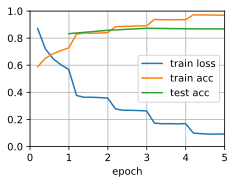

In [8]:
lr, num_epochs = 0.001, 5
trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': lr})
loss = gluon.loss.SoftmaxCrossEntropyLoss()
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, ctx)

Below, we use the trained model to classify sentiments of two simple sentences.

In [9]:
d2l.predict_sentiment(net, vocab, 'this movie is so great')

'positive'

In [10]:
d2l.predict_sentiment(net, vocab, 'this movie is so bad')

'negative'

## Summary

* We can use one-dimensional convolution to process and analyze timing data.
* A one-dimensional cross-correlation operation with multiple input channels can be regarded as a two-dimensional cross-correlation operation with a single input channel.
* The input of the max-over-time pooling layer can have different numbers of timesteps on each channel.
* TextCNN mainly uses a one-dimensional convolutional layer and max-over-time pooling layer.


## Exercises

1. Tune the hyper-parameters and compare the two sentiment analysis methods, using recurrent neural networks and using convolutional neural networks, as regards accuracy and operational efficiency.
1. Can you further improve the accuracy of the model on the test set by using the three methods introduced in the previous section: tuning hyper-parameters, using larger pre-trained word vectors, and using the spaCy word tokenization tool?
1. What other natural language processing tasks can you use textCNN for?


## [Discussions](https://discuss.mxnet.io/t/2392)

![](../img/qr_sentiment-analysis-cnn.svg)